# Pet Recommendation System

In this kernel we'll be building a Pet Recommendation System using https://github.com/sahityashetty19/pet-recommender-system/tree/master/data Dataset. 

The user is able to input the name of a dog breed (as a string), for which the system will have to return a set of the breeds that are most similar to this breed based on a specific attribute (excluding itself). To aid this the dataset will contain a set of dictionary dogs, mapping to dog breeds to various adgectives describing that breed's typical attributes such as its height, weight, size. In this context, two breeds are more similar the more attributes they share.

In [2]:
# import required libraries
import pandas as pd
import numpy as np 
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go

%matplotlib inline
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import chi2_contingency

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import cluster

from pca import pca as pca_2
# from ipynb.fs.full.functions import *
#from bioinfokit.visuz import cluster

# Data Preparation
### Cleaning the data 
Part I: Identify and correct mistakes
- Messy datasets
- Identify columns that contain a single value
- Delete columns that contain a single value
- Consider columns that have very few values
- Remove columns that have a low variance
- Identify rows that contain duplicate data
- Delete rows that contain duplicate data

In [3]:
# load the dataset
dataset = pd.read_csv('dogs.csv', na_values='?', index_col='|')
print(dataset.shape)

(199, 40)


In [4]:
header = ['url','shedding','overall_health','groom','weight_gain','drooling','general_health','size','wander','intelligence',
          'overall_trainability','prey_drive','mouthiness','bark','train','playful','energy','exercise','overall_exerciseneeds',
          'exercise_intensity','cold_weather','novice_owners','sensitivity','overall_adaptability','hot_weather','alone',
          'apartment','family_affection','friendly_strangers','overall_friendly','kid_friendly','dog_friendly','breed_group',
          'max_lifespan','min_lifespan','max_weight','min_weight','min_height','max_height','shoulder_height']
dataset.index.names = ['breed']
dataset.columns = header
dataset.head(5)

url  shedding  \
breed                                                                        
Azawakh                    http://dogtime.com/dog-breeds/azawakh         3   
Fox Terrier            http://dogtime.com/dog-breeds/fox-terrier         4   
Norwegian Buhund  http://dogtime.com/dog-breeds/norwegian-buhund         2   
Clumber Spaniel    http://dogtime.com/dog-breeds/clumber-spaniel         2   
Rottweiler              http://dogtime.com/dog-breeds/rottweiler         3   

                  overall_health  groom  weight_gain  drooling  \
breed                                                            
Azawakh                        4      5          3.0         5   
Fox Terrier                    3      2          2.0         3   
Norwegian Buhund               3      2          3.0         5   
Clumber Spaniel                3      2          4.0         2   
Rottweiler                     4      5          5.0         2   

                  general_health  size  wander  intelligence  ...  \
breed                                                         ...   
Azawakh                      3.0   3.0     2.0             3  ...   
Fox Terrier                  4.0   2.0     3.0             4  ...   
Norwegian Buhund             3.0   3.0     4.0             4  ...   
Clumber Spaniel              2.0   4.0     3.0             4  ...   
Rottweiler                   1.0   5.0     2.0             4  ...   

                  kid_friendly  dog_friendly    breed_group  max_lifespan  \
breed                                                                       
Azawakh                      3             3     Hound Dogs            15   
Fox Terrier                  4             2   Terrier Dogs            15   
Norwegian Buhund             3             3   Herding Dogs            15   
Clumber Spaniel              3             4  Sporting Dogs            12   
Rottweiler                   4             3   Working Dogs            11   

                  min_lifespan  max_weight  min_weight    min_height  \
breed                                                                  
Azawakh                     12        55.0          33        1 foot   
Fox Terrier                 10        19.0          15  Up to 1 foot   
Norwegian Buhund            12        40.0          26        1 foot   
Clumber Spaniel             12        85.0          55        1 foot   
Rottweiler                   8       130.0          85        1 foot   

                                      max_height  \
breed                                              
Azawakh                      11 inches to 2 feet   
Fox Terrier        3 inches tall at the shoulder   
Norwegian Buhund              4 inches to 1 foot   
Clumber Spaniel               5 inches to 1 foot   
Rottweiler                   10 inches to 2 feet   

                                 shoulder_height  
breed                                             
Azawakh            5 inches tall at the shoulder  
Fox Terrier                                  NaN  
Norwegian Buhund   6 inches tall at the shoulder  
Clumber Spaniel    8 inches tall at the shoulder  
Rottweiler         3 inches tall at the shoulder  

[5 rows x 40 columns]

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, Azawakh to Leonberger
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   url                    199 non-null    object 
 1   shedding               199 non-null    int64  
 2   overall_health         199 non-null    int64  
 3   groom                  199 non-null    int64  
 4   weight_gain            198 non-null    float64
 5   drooling               199 non-null    int64  
 6   general_health         198 non-null    float64
 7   size                   198 non-null    float64
 8   wander                 198 non-null    float64
 9   intelligence           199 non-null    int64  
 10  overall_trainability   199 non-null    int64  
 11  prey_drive             194 non-null    float64
 12  mouthiness             198 non-null    float64
 13  bark                   198 non-null    float64
 14  train                  198 non-null    float64
 15

In [6]:
dataset['min_lifespan']= pd.to_numeric(dataset['min_lifespan'],errors='coerce')
dataset['min_weight']= pd.to_numeric(dataset['min_weight'],errors='coerce')

# drop overall_features - does not define a feature
dataset = dataset.drop(['overall_health','overall_trainability','overall_exerciseneeds','overall_adaptability',
                       'overall_friendly','url','min_height','max_height','shoulder_height'], axis = 1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199 entries, Azawakh to Leonberger
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shedding            199 non-null    int64  
 1   groom               199 non-null    int64  
 2   weight_gain         198 non-null    float64
 3   drooling            199 non-null    int64  
 4   general_health      198 non-null    float64
 5   size                198 non-null    float64
 6   wander              198 non-null    float64
 7   intelligence        199 non-null    int64  
 8   prey_drive          194 non-null    float64
 9   mouthiness          198 non-null    float64
 10  bark                198 non-null    float64
 11  train               198 non-null    float64
 12  playful             198 non-null    float64
 13  energy              199 non-null    int64  
 14  exercise            199 non-null    int64  
 15  exercise_intensity  198 non-null    float64
 16  

Features dropped here are because they are redundant or do not provide useful information.

In [7]:
# locate rows of duplicate data
dups = dataset.duplicated().sum()
print('The amount of duplicated data is:',dups)

The amount of duplicated data is: 0


Part II: Mark and remove missing data
- Mark missing values
- Missing values cause problems
- Remove rows with missing values

In [8]:
columnStatistics = pd.DataFrame(dataset.max(axis=0))
columnStatistics.columns = ['MaxValues']

columnStatistics['MinValues'] = dataset.min(axis=0)
uniqueCounts = pd.DataFrame(columnStatistics.index)
uniqueCounts.set_index(0, inplace=True)
uniqueCounts['UniqueValues'] = np.nan
for col in dataset:
    uniqueCounts.loc[col]['UniqueValues'] = dataset[col].nunique()
columnStatistics['UniqueValues'] = uniqueCounts['UniqueValues']

columnStatistics
# likert scale from a scale of 1 to 5, no zero min val

MaxValues       MinValues  UniqueValues
shedding                       5               1           5.0
groom                          5               1           5.0
weight_gain                  5.0             1.0           5.0
drooling                       5               1           5.0
general_health               5.0             1.0           5.0
size                         5.0             1.0           5.0
wander                       5.0             1.0           5.0
intelligence                   5               2           4.0
prey_drive                   5.0             1.0           5.0
mouthiness                   5.0             1.0           5.0
bark                         5.0             1.0           5.0
train                        5.0             1.0           5.0
playful                      5.0             1.0           5.0
energy                         5               2           4.0
exercise                       5               2           4.0
exercise_intensity           5.0             1.0           5.0
cold_weather                   5               1           5.0
novice_owners                  5               1           5.0
sensitivity                    5               2           4.0
hot_weather                    5               1           5.0
alone                          5               1           5.0
apartment                      5               1           5.0
family_affection               5               2           4.0
friendly_strangers             5               1           5.0
kid_friendly                   5               1           5.0
dog_friendly                   5               1           5.0
breed_group         Working Dogs  Companion Dogs           8.0
max_lifespan                  20               8          12.0
min_lifespan                15.0             6.0          10.0
max_weight                 220.0             6.0          55.0
min_weight                 130.0             3.0          41.0

In [9]:
# Look for missing data in each feature
for i in dataset.columns:
    num_missing = (dataset[[i]].isnull()).sum()
    perc = num_missing/dataset.shape[0]*100
    print('> %s, Missing: %d (%.1f%%)' % (i,num_missing,perc))

> shedding, Missing: 0 (0.0%)
> groom, Missing: 0 (0.0%)
> weight_gain, Missing: 1 (0.5%)
> drooling, Missing: 0 (0.0%)
> general_health, Missing: 1 (0.5%)
> size, Missing: 1 (0.5%)
> wander, Missing: 1 (0.5%)
> intelligence, Missing: 0 (0.0%)
> prey_drive, Missing: 5 (2.5%)
> mouthiness, Missing: 1 (0.5%)
> bark, Missing: 1 (0.5%)
> train, Missing: 1 (0.5%)
> playful, Missing: 1 (0.5%)
> energy, Missing: 0 (0.0%)
> exercise, Missing: 0 (0.0%)
> exercise_intensity, Missing: 1 (0.5%)
> cold_weather, Missing: 0 (0.0%)
> novice_owners, Missing: 0 (0.0%)
> sensitivity, Missing: 0 (0.0%)
> hot_weather, Missing: 0 (0.0%)
> alone, Missing: 0 (0.0%)
> apartment, Missing: 0 (0.0%)
> family_affection, Missing: 0 (0.0%)
> friendly_strangers, Missing: 0 (0.0%)
> kid_friendly, Missing: 0 (0.0%)
> dog_friendly, Missing: 0 (0.0%)
> breed_group, Missing: 0 (0.0%)
> max_lifespan, Missing: 0 (0.0%)
> min_lifespan, Missing: 4 (2.0%)
> max_weight, Missing: 6 (3.0%)
> min_weight, Missing: 16 (8.0%)


In [10]:
# input missing values
bool_series = pd.isnull(dataset["weight_gain"])
dataset[bool_series]

shedding  groom  weight_gain  drooling  general_health  \
breed                                                                      
Korean Jindo Dog         3      4          NaN         1             NaN   

                  size  wander  intelligence  prey_drive  mouthiness  ...  \
breed                                                                 ...   
Korean Jindo Dog   NaN     NaN             5         5.0         NaN  ...   

                  apartment  family_affection  friendly_strangers  \
breed                                                               
Korean Jindo Dog          4                 4                   4   

                  kid_friendly  dog_friendly    breed_group  max_lifespan  \
breed                                                                       
Korean Jindo Dog             4             3  Sporting Dogs            15   

                  min_lifespan  max_weight  min_weight  
breed                                                   
Korean Jindo Dog          12.0        60.0        35.0  

[1 rows x 31 columns]

<b>From the dataframe above, 9/31 attributes are missing for this specific breed. Hence, drop the row.</b>

In [11]:
dataset = dataset.drop(labels='Korean Jindo Dog')
dataset.loc[dataset.index == 'Korean Jindo Dog']

index_list = dataset.index.tolist()

<b>Next, we visualize the prey_drive attribute to determine how to handle the missing values</b>

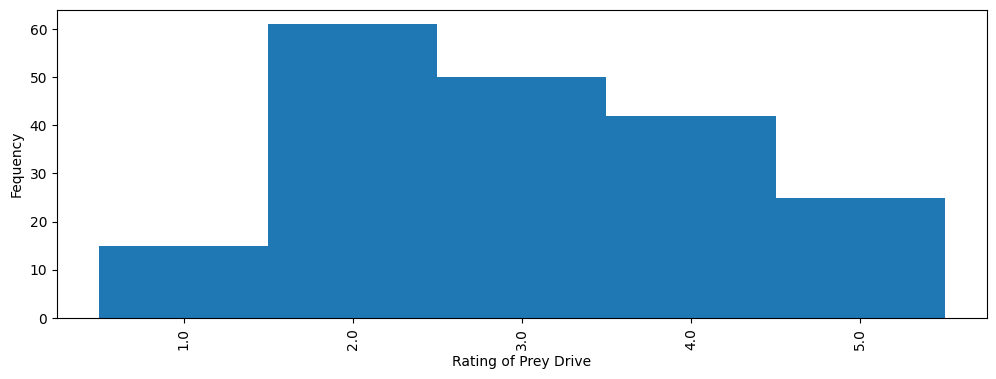

The median of prey_drive rating is: 3.0
The mean of prey_drive rating is: 3.0


In [12]:
# ############################################## CANNOT DO THIS
# We need to find the missing data

prey_drive = dataset['prey_drive'].value_counts().sort_index()
fig, ax = plt.subplots(figsize=(12, 4))
ax = prey_drive.plot(kind='bar',width=1.0)
ax.set(xlabel = "Rating of Prey Drive",
       ylabel = "Fequency")
plt.show()
print('The median of prey_drive rating is:',dataset["prey_drive"].median())
print('The mean of prey_drive rating is:',round(dataset["prey_drive"].mean(),0))

<b>Since there is no difference between the mean and median: replace with either</b>

In [13]:
# ############################################## CANNOT DO THIS
# We need to find the missing data


# Replace the missing values with mean/median
# Since it is an ordinal data, a median is more suitable
dataset["prey_drive"].fillna(dataset['prey_drive'].mean(), inplace = True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, Azawakh to Leonberger
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shedding            198 non-null    int64  
 1   groom               198 non-null    int64  
 2   weight_gain         198 non-null    float64
 3   drooling            198 non-null    int64  
 4   general_health      198 non-null    float64
 5   size                198 non-null    float64
 6   wander              198 non-null    float64
 7   intelligence        198 non-null    int64  
 8   prey_drive          198 non-null    float64
 9   mouthiness          198 non-null    float64
 10  bark                198 non-null    float64
 11  train               198 non-null    float64
 12  playful             198 non-null    float64
 13  energy              198 non-null    int64  
 14  exercise            198 non-null    int64  
 15  exercise_intensity  198 non-null    float64
 16  

In [14]:
# format fields
dataset = dataset.astype({header[4]: 'int64', header[6]: 'int64', header[7]: 'int64', header[8]: 'int64',
                          header[11]: 'int64', header[12]: 'int64', header[13]: 'int64', header[14]: 'int64',
                          header[15]: 'int64', header[19]: 'int64', header[33]: 'int64', header[34]: float,
                          header[36]: float})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, Azawakh to Leonberger
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   shedding            198 non-null    int64  
 1   groom               198 non-null    int64  
 2   weight_gain         198 non-null    int64  
 3   drooling            198 non-null    int64  
 4   general_health      198 non-null    int64  
 5   size                198 non-null    int64  
 6   wander              198 non-null    int64  
 7   intelligence        198 non-null    int64  
 8   prey_drive          198 non-null    int64  
 9   mouthiness          198 non-null    int64  
 10  bark                198 non-null    int64  
 11  train               198 non-null    int64  
 12  playful             198 non-null    int64  
 13  energy              198 non-null    int64  
 14  exercise            198 non-null    int64  
 15  exercise_intensity  198 non-null    int64  
 16  

<b>Investigate weight and lifespan</b>

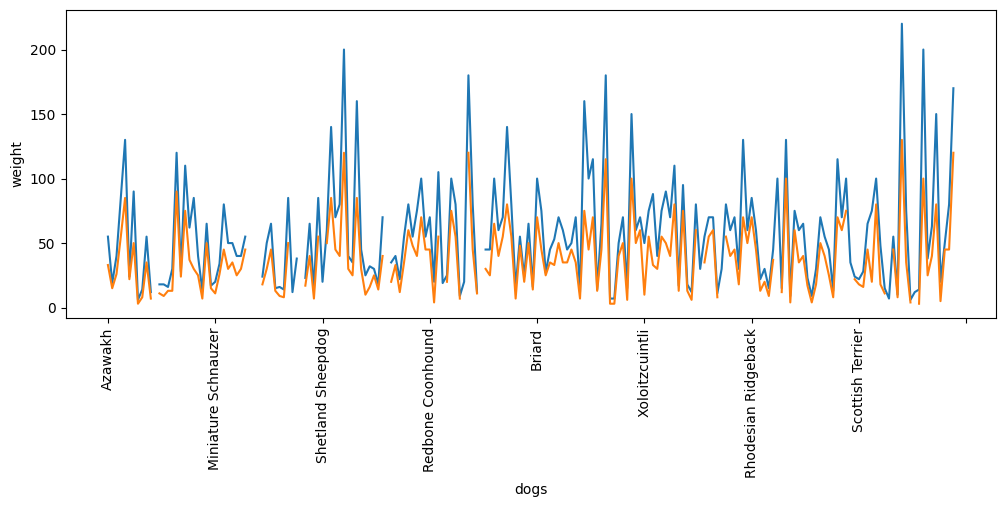

In [15]:
weight_max = dataset['max_weight']
weight_min = dataset['min_weight']
weight_max.plot.line(figsize=(12,4))
weight_min.plot.line()
plt.ylabel("weight")
plt.xlabel("dogs")
plt.xticks(rotation=90)
plt.show()

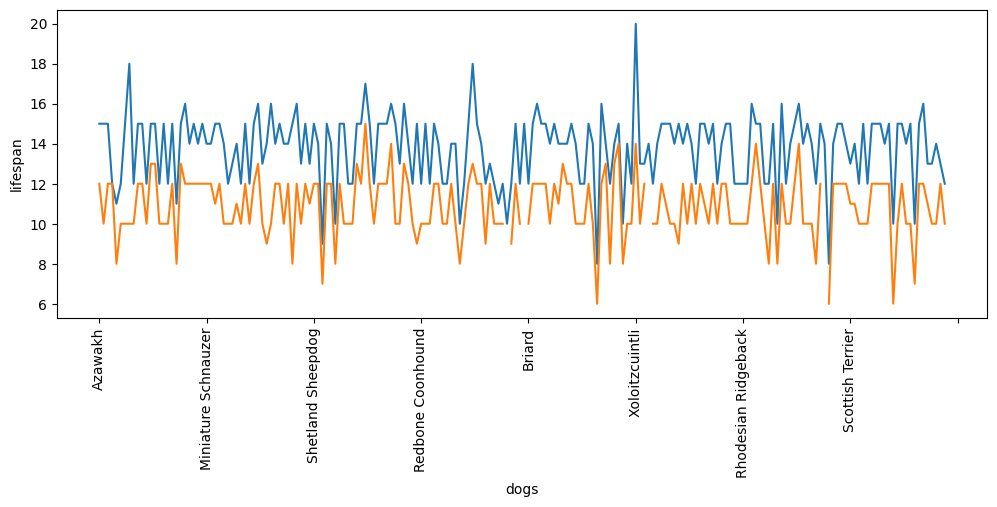

In [16]:
lifespan_max = dataset['max_lifespan']
lifespan_min = dataset['min_lifespan']
lifespan_max.plot.line(figsize=(12,4))
lifespan_min.plot.line()
plt.ylabel("lifespan")
plt.xlabel("dogs")
plt.xticks(rotation=90)
plt.show()

In [17]:
# no interesting / useful analysis can be made from the maximum and minimum besides the range
# if (max-min)/2 != mean of the weight
dataset = dataset.drop(['max_weight','min_weight'], axis = 1)
dataset = dataset.drop(['max_lifespan','min_lifespan'], axis = 1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, Azawakh to Leonberger
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   shedding            198 non-null    int64 
 1   groom               198 non-null    int64 
 2   weight_gain         198 non-null    int64 
 3   drooling            198 non-null    int64 
 4   general_health      198 non-null    int64 
 5   size                198 non-null    int64 
 6   wander              198 non-null    int64 
 7   intelligence        198 non-null    int64 
 8   prey_drive          198 non-null    int64 
 9   mouthiness          198 non-null    int64 
 10  bark                198 non-null    int64 
 11  train               198 non-null    int64 
 12  playful             198 non-null    int64 
 13  energy              198 non-null    int64 
 14  exercise            198 non-null    int64 
 15  exercise_intensity  198 non-null    int64 
 16  cold_weather      

min & max weight, and min & max lifespan are dropped here because no useful analysis can be derived from these features.

### Feature Selection (Correlation)
Part I: Identify and reduce the features in the dataset that are highly correlated.<br>

In [18]:
corr = dataset.corr()
sns.set(font_scale=4)
mask = np.triu(np.ones_like(corr))
plt.figure(figsize=(100, 80))
sns.heatmap(corr, annot=True, cmap='RdBu', vmin=-1, mask=mask)
sns.set(font_scale=1)

<ipython-input-18-8d804e398875>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = dataset.corr()


<b>Observations:</b>
- Exercise and energy are highly positively correlated and should not be paired together in the same model with a value of 0.81.
- Next, friendly towards strangers and dog friendly & playful and intelligence have a weak positive correlation score of 0.6  
To verify the correlation, a bubble chart used to visualize the data. A bubble chart is a scatter plot in which a third dimension of the data is shown through the size of markers.

Text(0, 0.5, 'Energy Level')

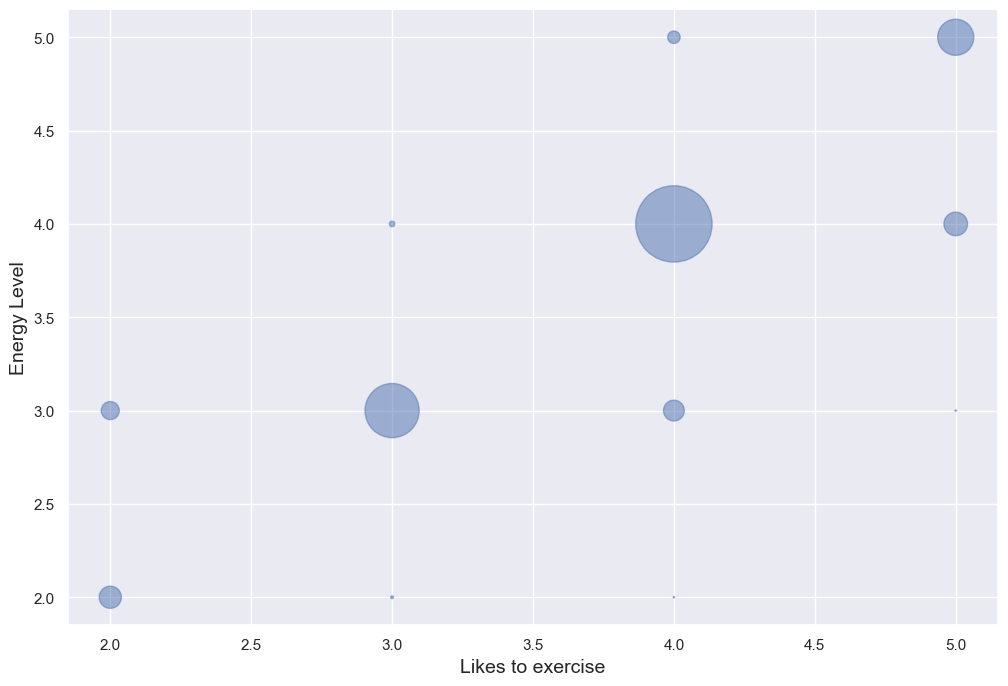

In [19]:
bubble_df = pd.DataFrame({'count' : dataset.groupby(['energy', 'exercise']).size()}).reset_index()
plt.figure(figsize=(12, 8))
plt.scatter(x=bubble_df['exercise'].values, y=bubble_df['energy'].values,
                  alpha=0.5,
                  s = bubble_df['count'].values **2)
plt.xlabel('Likes to exercise', size=14)
plt.ylabel('Energy Level', size=14)

Text(0, 0.5, 'Friendly to strangers')

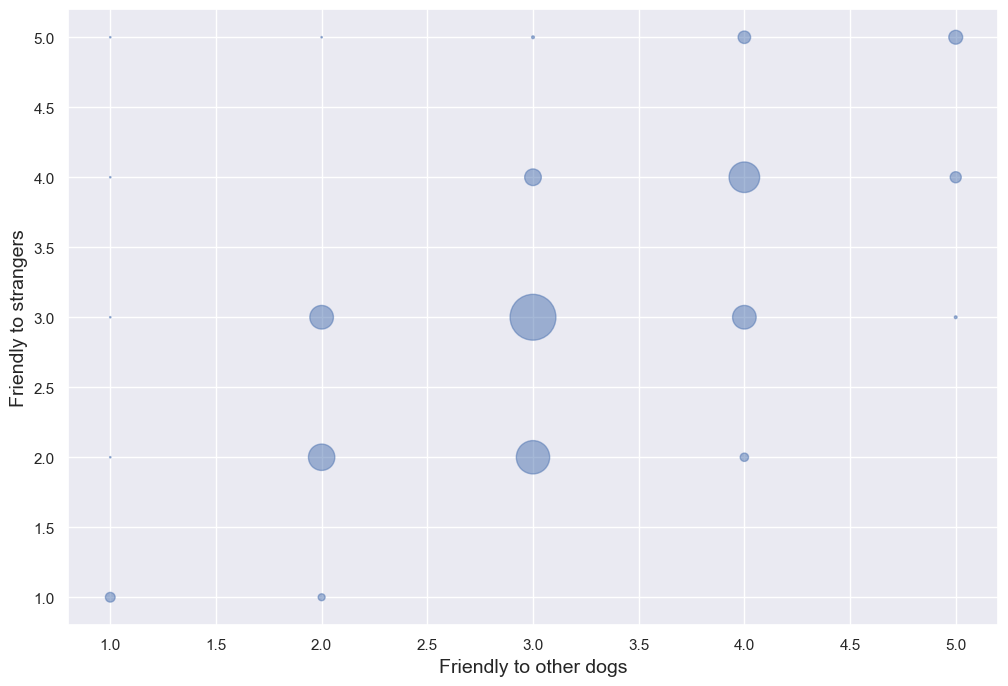

In [20]:
bubble_df = pd.DataFrame({'count' : dataset.groupby(['dog_friendly', 'friendly_strangers']).size()}).reset_index()
plt.figure(figsize=(12, 8))
plt.scatter(x=bubble_df['dog_friendly'].values, y=bubble_df['friendly_strangers'].values,
                  alpha=0.5,
                  s = bubble_df['count'].values **2)
plt.xlabel('Friendly to other dogs', size=14)
plt.ylabel('Friendly to strangers', size=14)

Text(0, 0.5, 'Intelligent')

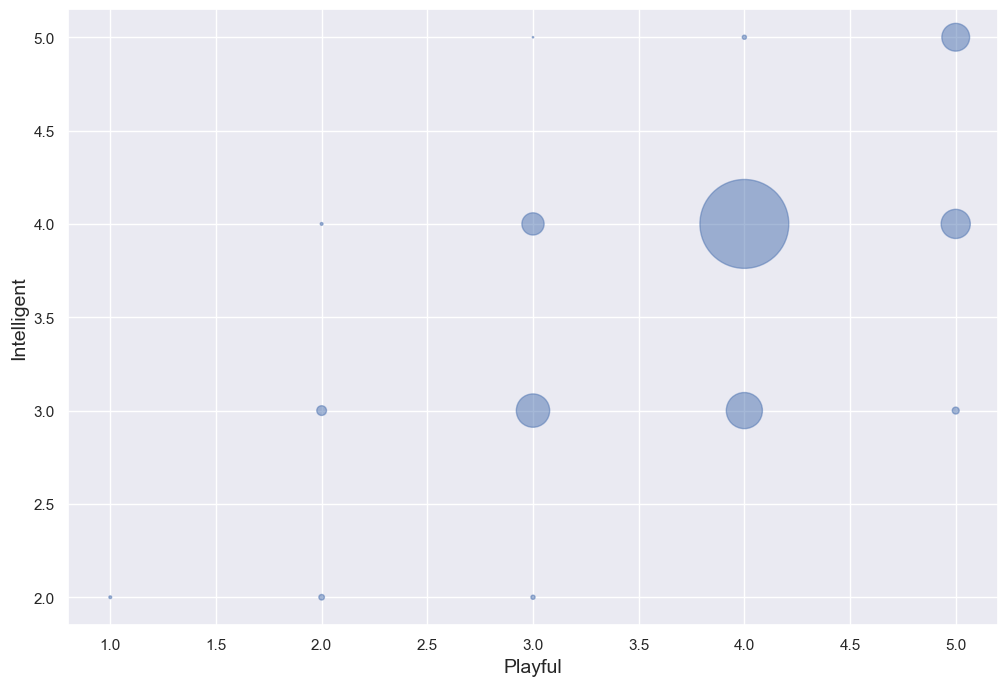

In [21]:
bubble_df = pd.DataFrame({'count' : dataset.groupby(['playful', 'intelligence']).size()}).reset_index()
plt.figure(figsize=(12, 8))
plt.scatter(x=bubble_df['playful'].values, y=bubble_df['intelligence'].values,
                  alpha=0.5,
                  s = bubble_df['count'].values **2)
plt.xlabel('Playful', size=14)
plt.ylabel('Intelligent', size=14)

Text(0, 0.5, 'Intelligent')

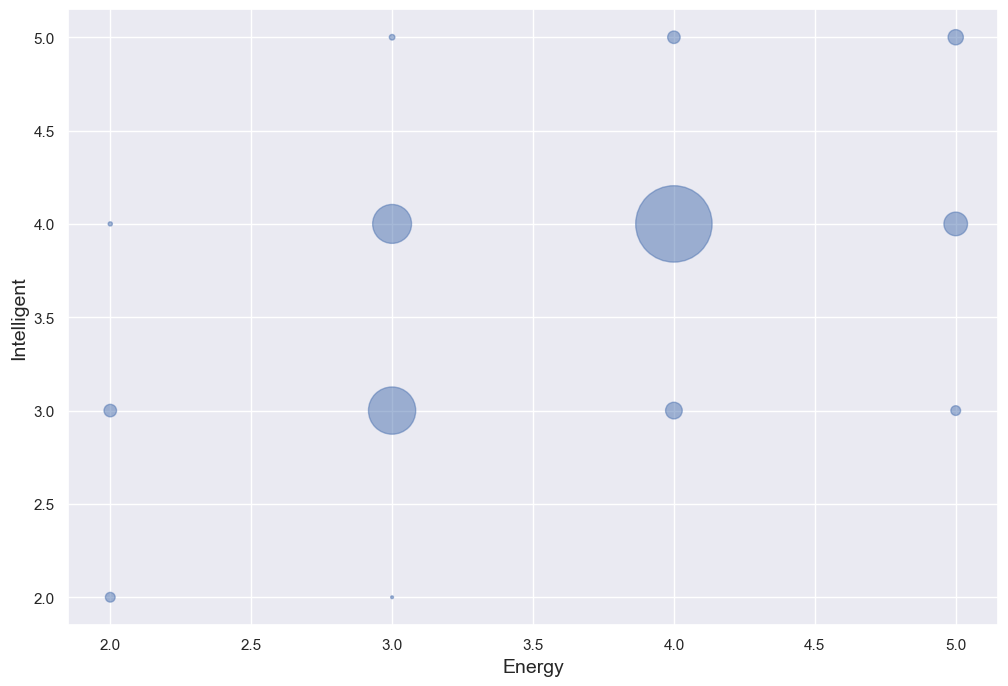

In [22]:
bubble_df = pd.DataFrame({'count' : dataset.groupby(['energy', 'intelligence']).size()}).reset_index()
x = np.array(bubble_df['energy'].values)
y = np.array(bubble_df['intelligence'].values)
plt.figure(figsize=(12, 8))

plt.scatter(x, y, alpha=0.5,s = bubble_df['count'].values **2)
#m, b = np.polyfit(x,y,1)
#plt.plot(x, m*x + b)
plt.xlabel('Energy', size=14)
plt.ylabel('Intelligent', size=14)

In [23]:
dataset = dataset.drop(['exercise','friendly_strangers', 'intelligence', 'energy', 'cold_weather'], axis = 1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, Azawakh to Leonberger
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   shedding            198 non-null    int64 
 1   groom               198 non-null    int64 
 2   weight_gain         198 non-null    int64 
 3   drooling            198 non-null    int64 
 4   general_health      198 non-null    int64 
 5   size                198 non-null    int64 
 6   wander              198 non-null    int64 
 7   prey_drive          198 non-null    int64 
 8   mouthiness          198 non-null    int64 
 9   bark                198 non-null    int64 
 10  train               198 non-null    int64 
 11  playful             198 non-null    int64 
 12  exercise_intensity  198 non-null    int64 
 13  novice_owners       198 non-null    int64 
 14  sensitivity         198 non-null    int64 
 15  hot_weather         198 non-null    int64 
 16  alone             

### Data Visualization of breed_group

In [24]:
# Split data into features (X) and Class Label (Y) using numpy
x_list = list(dataset.columns.values)
y_list = dataset.breed_group.tolist()
y_list = list(dict.fromkeys(y_list))

x_list.remove('breed_group')
X=dataset[x_list].to_numpy()
Y=dataset[['breed_group']].to_numpy()
Y=Y.reshape(-1)

print(X.shape)

(198, 21)


Text(0.5, 1.0, 'Plot of data:Feature 1 verus Feature 2')

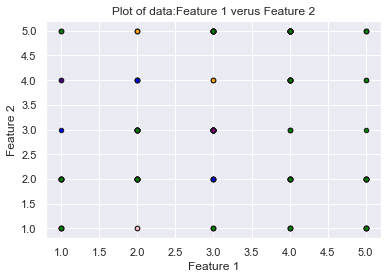

In [24]:
hnd = Y == y_list[0]
ter = Y == y_list[1]
her = Y == y_list[2]
spt = Y == y_list[3]
wrk = Y == y_list[4]
hyb = Y == y_list[5]
com = Y == y_list[6]
mix = Y == y_list[7]

ori= plt.scatter(X[hnd, 0], X[hnd, 1], c="red",s=20, edgecolor='k')
plt.scatter(X[ter, 0], X[ter, 1], c="yellow", s=20, edgecolor='k')
plt.scatter(X[her, 0], X[her, 1], c="orange", s=20, edgecolor='k')
plt.scatter(X[spt, 0], X[spt, 1], c="pink", s=20, edgecolor='k')
plt.scatter(X[wrk, 0], X[wrk, 1], c="blue", s=20, edgecolor='k')
plt.scatter(X[hyb, 0], X[hyb, 1], c="indigo", s=20, edgecolor='k')
plt.scatter(X[com, 0], X[com, 1], c="green", s=20, edgecolor='k')
plt.scatter(X[mix, 0], X[mix, 1], c="purple", s=20, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Plot of data:Feature 1 verus Feature 2")

Ordinal data by itself does not provide much information visually at all.

Text(0.5, 1.0, 'Plot of data:Feature 1 verus Feature 2')

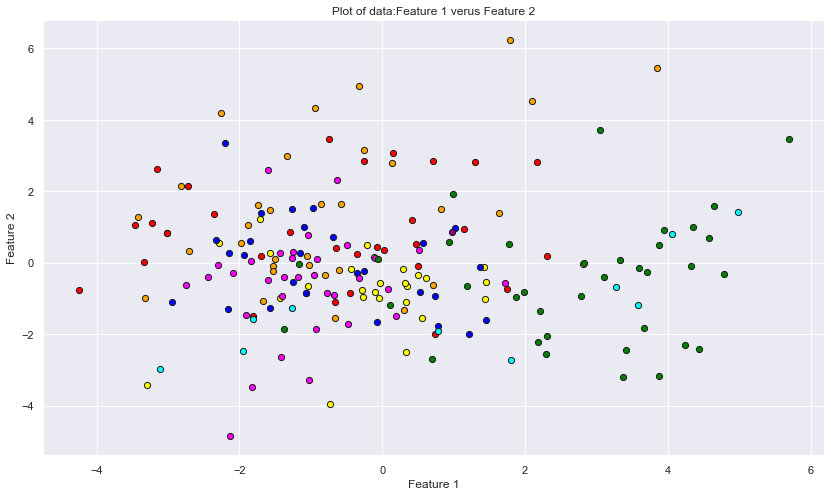

In [25]:
pca = PCA(n_components=2) #covariance matrix
pca.fit(X)
o = pca.transform(X)
size = 38

plt.figure(figsize=(14, 8))
ori= plt.scatter(o[hnd, 0], o[hnd, 1], c="red",s=size, edgecolor='k')
plt.scatter(o[ter, 0], o[ter, 1], c="yellow", s=size, edgecolor='k')
plt.scatter(o[her, 0], o[her, 1], c="blue", s=size, edgecolor='k')
plt.scatter(o[spt, 0], o[spt, 1], c="magenta", s=size, edgecolor='k')
plt.scatter(o[wrk, 0], o[wrk, 1], c="orange", s=size, edgecolor='k')
plt.scatter(o[hyb, 0], o[hyb, 1], c="cyan", s=size, edgecolor='k')
plt.scatter(o[com, 0], o[com, 1], c="green", s=size, edgecolor='k')
plt.scatter(o[mix, 0], o[mix, 1], c="purple", s=size, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Plot of data:Feature 1 verus Feature 2")

Text(0.5, 1.0, 'Plot of data:Feature 1 verus Feature 2')

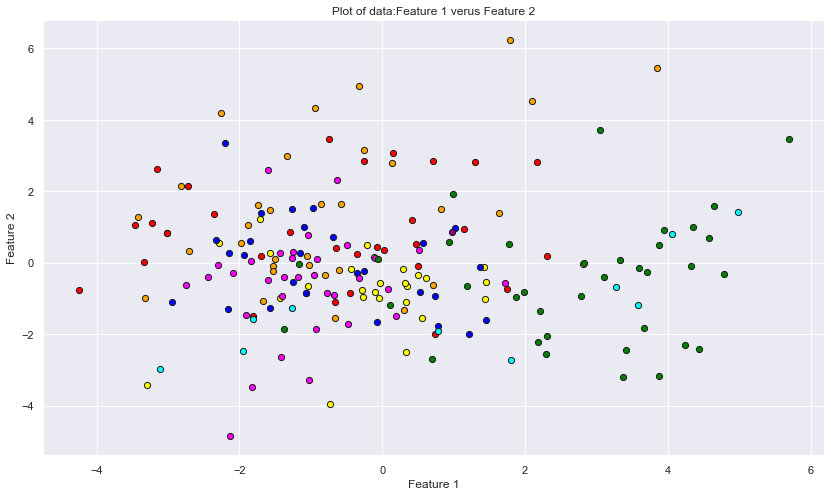

In [26]:
pca = PCA(n_components=21) #covariance matrix
pca.fit(X)
o = pca.transform(X)

plt.figure(figsize=(14,8))
ori= plt.scatter(o[hnd, 0], o[hnd, 1], c="red",s=size, edgecolor='k')
plt.scatter(o[ter, 0], o[ter, 1], c="yellow", s=size, edgecolor='k')
plt.scatter(o[her, 0], o[her, 1], c="blue", s=size, edgecolor='k')
plt.scatter(o[spt, 0], o[spt, 1], c="magenta", s=size, edgecolor='k')
plt.scatter(o[wrk, 0], o[wrk, 1], c="orange", s=size, edgecolor='k')
plt.scatter(o[hyb, 0], o[hyb, 1], c="cyan", s=size, edgecolor='k')
plt.scatter(o[com, 0], o[com, 1], c="green", s=size, edgecolor='k')
plt.scatter(o[mix, 0], o[mix, 1], c="purple", s=size, edgecolor='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Plot of data:Feature 1 verus Feature 2")


### Feature Selection (Dimensionality Reduction - PCA)

In [27]:
def load_dataset(data):
    # retrieve array
    #data = pd.read_csv('dogs.csv',header=None)
    dataset = data.values
    #split into input and output variables (features and lables)
    X = dataset[:,0:]
    y = np.asarray(data.index)
    X = X.astype(str)
    return X, y

def prepare_inputs(X_train,X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = oe.transform(X_train)
    X_test_enc = oe.transform(X_test)
    return X_train_enc, X_test_enc

def prepare_targets(y_train,y_test):
    le = LabelEncoder()
    le.fit(dataset.index)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc , y_test_enc

In [28]:
# X , y = load_dataset(dataset)
# # split into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2 , random_state=1)
# # prepare input data (dog's attributes)
# X_train_enc , X_test_enc = prepare_inputs(X_train, X_test)
# # prepare output data (label: breed)
# y_train_enc , y_test_enc = prepare_targets(y_train, y_test)
# print(X_train_enc.shape,X_test_enc.shape)

In [29]:
# fitting of the data
# dataset_nogroup = dataset.drop(['breed_group'], axis = 1)

############################ LAST LOCATION THAT THE ORIGINAL DATASET HAS BEEN TOUCHED #########################################
dataset = dataset.drop(['breed_group'], axis = 1)

x = StandardScaler().fit_transform(dataset)
# standardization 
x = pd.DataFrame(x, columns=dataset.columns.values)
print(x.shape) 
x.round(2).head()

pca_fitting_dataset = x.copy()
pca_fitting_dataset

(198, 21)


shedding     groom  weight_gain  drooling  general_health      size  \
0   -0.072519  1.367292    -0.306707  1.248458        0.108523  0.011130   
1    0.772117 -0.821849    -1.452518 -0.517218        1.085233 -0.723429   
2   -0.917155 -0.821849    -0.306707  1.248458        0.108523  0.011130   
3   -0.917155 -0.821849     0.839104 -1.400057       -0.868186  0.745688   
4   -0.072519  1.367292     1.984915 -1.400057       -1.844896  1.480247   
..        ...       ...          ...       ...             ...       ...   
193 -0.917155  0.637578    -0.306707 -0.517218        0.108523  1.480247   
194  0.772117 -0.821849    -1.452518  1.248458        0.108523 -0.723429   
195  1.616752  1.367292    -2.598329  1.248458        1.085233  0.011130   
196 -0.072519  1.367292    -0.306707 -0.517218        0.108523  0.745688   
197 -1.761791  0.637578     0.839104 -0.517218       -1.844896  1.480247   

       wander  prey_drive  mouthiness      bark  ...   playful  \
0   -1.028776    0.863296    1.647556  0.663705  ... -2.086156   
1   -0.210713   -0.872061   -0.527218 -0.309729  ...  1.299573   
2    0.607350   -0.872061   -0.527218 -0.309729  ...  0.170996   
3   -0.210713   -0.004382   -0.527218  0.663705  ... -0.957580   
4   -1.028776   -0.872061   -0.527218 -0.309729  ...  0.170996   
..        ...         ...         ...       ...  ...       ...   
193  0.607350   -0.872061   -0.527218 -0.309729  ... -0.957580   
194 -1.028776    0.863296    0.560169 -0.309729  ...  0.170996   
195  0.607350    1.730975    0.560169  1.637140  ... -0.957580   
196  1.425413    0.863296    0.560169 -1.283164  ... -0.957580   
197 -1.028776    0.863296    0.560169  0.663705  ...  0.170996   

     exercise_intensity  novice_owners  sensitivity  hot_weather     alone  \
0             -0.439097      -1.090119    -0.439943     0.934353  0.266395   
1              0.634251      -0.175528    -0.439943     0.934353  0.266395   
2              0.634251      -0.175528    -0.439943    -1.308094  1.342848   
3             -0.439097       0.739064    -0.439943    -0.186871  0.266395   
4              0.634251      -1.090119    -0.439943    -0.186871  0.266395   
..                  ...            ...          ...          ...       ...   
193           -0.439097      -1.090119     0.786940    -0.186871  0.266395   
194           -0.439097       1.653655    -0.439943    -0.186871  0.266395   
195           -0.439097      -0.175528    -0.439943     0.934353 -0.810058   
196            0.634251      -1.090119    -0.439943    -0.186871 -0.810058   
197            0.634251      -0.175528     0.786940    -0.186871 -0.810058   

     apartment  family_affection  kid_friendly  dog_friendly  
0    -0.780122         -1.774095     -0.498170     -0.145248  
1    -0.026638         -0.463383      0.518713     -1.103886  
2    -0.780122         -0.463383     -0.498170     -0.145248  
3    -0.026638         -0.463383     -0.498170      0.813390  
4    -0.780122         -0.463383      0.518713     -0.145248  
..         ...               ...           ...           ...  
193  -1.533606         -1.774095     -1.515053     -1.103886  
194   1.480329          0.847329      0.518713     -0.145248  
195  -0.026638          0.847329      0.518713     -0.145248  
196  -1.533606         -0.463383      0.518713      0.813390  
197  -1.533606          0.847329      0.518713     -0.145248  

[198 rows x 21 columns]

In [30]:
print(len(dataset.columns))

21


The first column is the first PC and so on.

[0.18132237 0.13081045 0.10941498 0.08321664 0.06842189 0.06272356
 0.05460913 0.04869075 0.04063073 0.0369447  0.03156475 0.02604198
 0.02091532 0.01942139 0.01546508 0.01478121 0.01349704 0.01226091
 0.01124856 0.00931699 0.00870156]


Text(0.5, 1.0, 'Plot of eigen variance energy captured by Principle component')

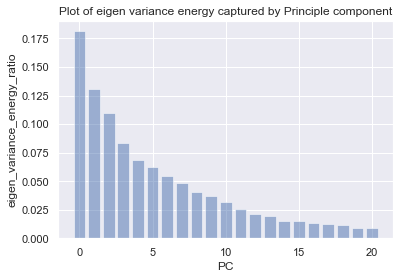

In [31]:
eigen_energy=pca.explained_variance_ratio_
print(eigen_energy)
plt.bar(range(0,21), eigen_energy, alpha=0.5, align='center', label='individual explained variance')
plt.xlabel('PC')
plt.ylabel('eigen_variance_energy_ratio')
plt.title("Plot of eigen variance energy captured by Principle component")

In [32]:
sum = 0
iteration = 1
for i in eigen_energy:
    sum+= i
    print("First",iteration,"component's variance energy =",sum)
    iteration += 1

First 1 component's variance energy = 0.18132237434788423
First 2 component's variance energy = 0.31213282618364857
First 3 component's variance energy = 0.42154780889452703
First 4 component's variance energy = 0.5047644468973036
First 5 component's variance energy = 0.5731863390408961
First 6 component's variance energy = 0.6359099038525085
First 7 component's variance energy = 0.6905190333154732
First 8 component's variance energy = 0.7392097862212824
First 9 component's variance energy = 0.7798405162403085
First 10 component's variance energy = 0.8167852155094888
First 11 component's variance energy = 0.8483499620675621
First 12 component's variance energy = 0.8743919371817478
First 13 component's variance energy = 0.8953072577159283
First 14 component's variance energy = 0.914728646377222
First 15 component's variance energy = 0.9301937234537928
First 16 component's variance energy = 0.9449749304220137
First 17 component's variance energy = 0.9584719743021345
First 18 component's 

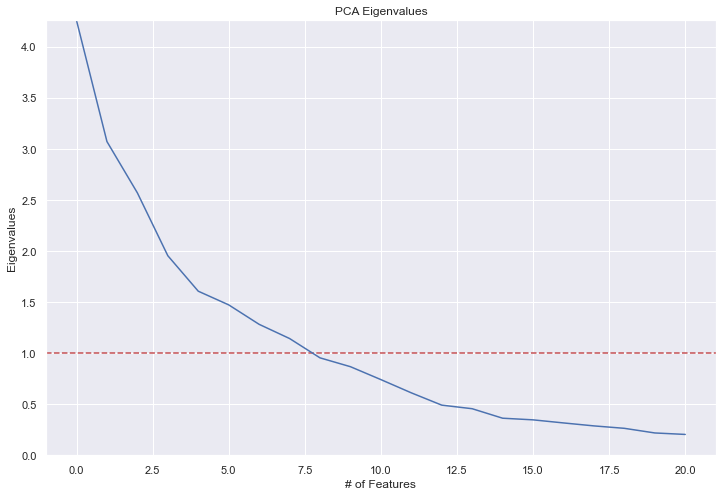

In [33]:
# scree plot
plt.figure(figsize=(12, 8))
plt.xlabel('# of Features')
plt.ylabel('Eigenvalues')
plt.title('PCA Eigenvalues')
plt.ylim(0,max(pca.explained_variance_))
plt.style.context('seaborn-whitegrid')
plt.axhline(y=1, color='r', linestyle='--')
plt.plot(pca.explained_variance_)
plt.show()

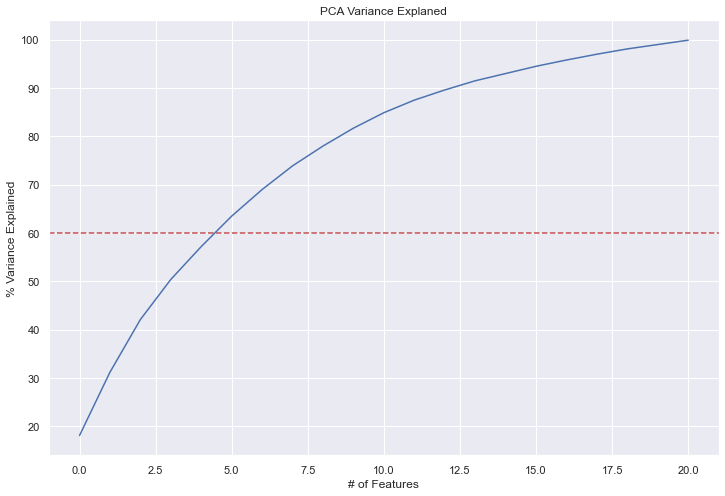

In [34]:
plt.figure(figsize=(12, 8))
plt.title('PCA Variance Explaned')
plt.xlabel('# of Features')
plt.ylabel('% Variance Explained')
plt.axhline(y=60, color='r', linestyle='--')

plt.plot(np.cumsum(np.round(pca.explained_variance_ratio_,decimals=3)*100))
plt.show()
#PCA1 is at 0 in xscale

To deal with a not-so-ideal scree plot curve, there are a couple ways:<br>

1) Kaiser rule: pick PCs with eigenvalues of at least 1. <br>
2) Proportion of variance plot: the selected PCs should be able to describe at least 80% of the variance.

In [35]:
pca = PCA(n_components= 6) #covariance matrix
pca.fit(x)
x_pca = pca.transform(x)
print(x_pca.shape)

(198, 6)


In [36]:
x_pca_df = pd.DataFrame(x_pca, columns=['PC1','PC2','PC3','PC4','PC5','PC6'])
# x_pca_df.head()
x_pca_df
# this shows the covariance matrix and it shows that PC2 is positively related to PC1 and so on 

PC1       PC2       PC3       PC4       PC5       PC6
0    2.947862 -1.910858 -1.234359 -0.773963 -0.439574 -0.396190
1   -1.023372 -0.266964 -1.168330  0.988487  1.288200  0.735497
2    0.026152 -1.262062  0.347861  0.604329  0.904210 -0.246747
3    0.141947  0.001900  2.031881 -0.939213  0.740631 -0.869691
4   -1.480568 -1.404436  2.823379 -0.208714 -0.870670  0.423976
..        ...       ...       ...       ...       ...       ...
193  0.182612 -2.812786  0.502424  1.539875  0.065560 -1.840069
194  1.352600  2.208871 -0.987751 -0.475175  0.310431  0.511194
195  1.540074 -0.112846 -3.357650 -1.362064 -1.883154  0.307702
196 -0.598753 -2.079754 -0.973253 -1.158077 -1.724250 -0.130731
197  0.018585 -0.816492  2.024243 -0.627858 -2.747880 -0.907679

[198 rows x 6 columns]

A scree plot displays how much variation each principal component captures from the data. The y axis is eigenvalues, which essentially stand for the amount of variation. Use a scree plot to select the principal components to keep. An ideal curve should be steep, then bends at an “elbow”  — this is your cutting-off point — and after that flattens out.<br>

If you end up with too many principal components (more than 3), PCA might not be the best way to visualize your data. Instead, consider other dimension reduction techniques, such as t-SNE and MDS.

PCs should at least describe 60% of the variance. Based on the figure PC 1-6 are enough to describe the data. (since 0 is PC1)

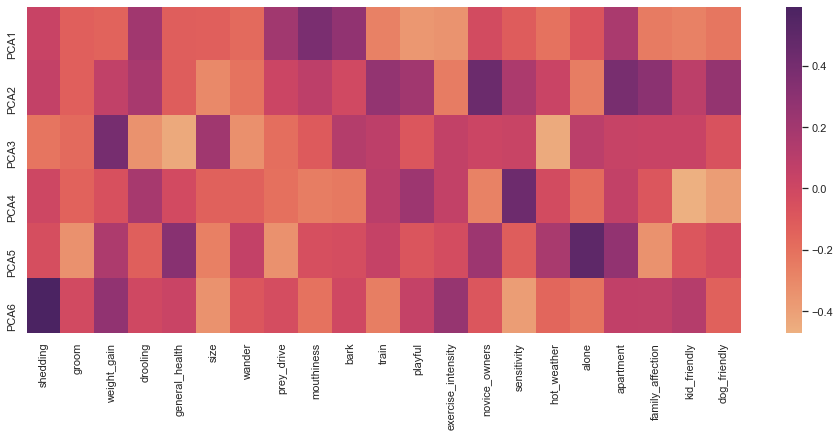

In [37]:
plt.figure(figsize=(16,6))
ax = sns.heatmap(pca.components_[0:6],
                 cmap="flare",
                 yticklabels=[ "PCA"+str(x) for x in range(1,7)],
                 xticklabels=list(dataset.columns))

In [38]:
components = pd.DataFrame(pca.components_, columns=x.columns)
components.rename(index= lambda x:'PC-' + str(x+1), inplace=True)

# Top 3 positive contributors
pd.DataFrame(components.columns.values[np.argsort(-components.values,axis=1)[:,:3]], 
             index=components.index, columns=['1st Max', '2nd Max','3rd Max'])

1st Max         2nd Max             3rd Max
PC-1     mouthiness            bark            drooling
PC-2  novice_owners       apartment    family_affection
PC-3    weight_gain            size                bark
PC-4    sensitivity         playful            drooling
PC-5          alone  general_health           apartment
PC-6       shedding     weight_gain  exercise_intensity

In [39]:
#var = pca.explained_variance_ratio_.sum()
#fig = px.scatter_3d(x_pca_df, x='PC1',  y='PC2',https://www.facebook.com/ z='PC3',title=f'Total Explained Variance: {var}',
#labels={'0':'PC1', '1':'PC2', '2':'PC3'})
#fig.show()

data = go.Scatter3d(
    x=x_pca[:,0],
    y = x_pca[:,1],
    z = x_pca[:,2],
    name = "",
    mode='markers',
    marker=dict(
        size=10,               
        opacity=0.8
)

)

dc_1 = go.Scatter3d( x = [0,pca.components_.T[0][0]*pca.explained_variance_[0]],
                     y = [0,pca.components_.T[0][1]*pca.explained_variance_[0]],
                     z = [0,pca.components_.T[0][2]*pca.explained_variance_[0]],
                     marker = dict( size = 1,
                                    color ="red"),
                     line = dict( color = "red",
                                width = 10),
                     name = "PC1"
                     )
dc_2 = go.Scatter3d( x = [0,pca.components_.T[1][0]*pca.explained_variance_[1]],
                   y = [0,pca.components_.T[1][1]*pca.explained_variance_[1]],
                   z = [0,pca.components_.T[1][2]*pca.explained_variance_[1]],
                   marker = dict( size = 1,
                                  color = "rgb(84,48,5)"),
                   line = dict( color = "green",
                                width = 10),
                   name = "PC2"
                 )
dc_3 = go.Scatter3d( x = [0,pca.components_.T[2][0]*pca.explained_variance_[2]],
                     y = [0,pca.components_.T[2][1]*pca.explained_variance_[2]],
                    z = [0,pca.components_.T[2][2]*pca.explained_variance_[2]],
                    marker = dict( size = 1,
                                  color = "rgb(84,48,5)"),
                     line = dict( color = "blue",
                                width = 10),
                     name = "PC3"
                 ) 

data = [data,dc_1,dc_2,dc_3]
layout = go.Layout(
    xaxis=dict(
        titlefont=dict(
           family='Courier New, monospace',
           size=18,
           color='#7f7f7f'
       )
   )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [40]:
#fig = px.scatter_3d(x_pca_df, x=3,  y=4, z=5)

#Make Plot.ly Layout
#mylayout = go.Layout(scene=dict(xaxis=dict(title="PCA4"),
#                                yaxis=dict(title="PCA5"),
#                                zaxis=dict(title="PCA6")),)
#fig.update_layout(mylayout)
#fig.show()

data = go.Scatter3d(
    x=x_pca[:,3],
    y = x_pca[:,4],
    z = x_pca[:,5],
    name = "data",
    mode='markers',
    marker=dict(
        size=2,               
        opacity=0.8
)

)

dc_1 = go.Scatter3d( x = [0,pca.components_.T[3][0]],
                     y = [0,pca.components_.T[3][1]],
                     z = [0,pca.components_.T[3][2]],
                     marker = dict( size = 1,
                                    color = "rgb(84,48,5)"),
                     line = dict( color = "red",
                                width = 10),
                     name = "PC4"
                     )
dc_2 = go.Scatter3d( x = [0,pca.components_.T[4][0]],
                   y = [0,pca.components_.T[4][1]],
                   z = [0,pca.components_.T[4][2]],
                   marker = dict( size = 1,
                                  color = "rgb(84,48,5)"),
                   line = dict( color = "green",
                                width = 10),
                   name = "PC5"
                 )
dc_3 = go.Scatter3d( x = [0,pca.components_.T[5][0]],
                     y = [0,pca.components_.T[5][1]],
                     z = [0,pca.components_.T[5][2]],
                     marker = dict( size = 1,
                                  color = "rgb(84,48,5)"),
                     line = dict( color = "blue",
                                width = 10),
                     name = "PC6"
                 ) 

data = [data,dc_1,dc_2,dc_3]
layout = go.Layout(
    xaxis=dict(
        title='PC1',
        titlefont=dict(
           family='Courier New, monospace',
           size=18,
           color='#7f7f7f'
       )
   )
)
fig = go.Figure(data=data, layout=layout)
fig.show()

In [41]:
# arr = x_pca_df.iloc[:3, 0:3].values
# data=[go.Scatter3d(x=[arr[0][0]], y=[arr[0][1]], z=[arr[0][2]],mode='markers', marker=dict(size=20, color='red'), opacity=0.8, name=y_train[0]),
#       go.Scatter3d(x=[arr[1][0]], y=[arr[1][1]], z=[arr[1][2]],mode='markers', marker=dict(size=30, color='blue'), opacity=0.3, name=y_train[1]),
#      go.Scatter3d(x=[arr[2][0]], y=[arr[2][1]], z=[arr[2][2]],mode='markers', marker=dict(size=30, color='green'), opacity=0.3, name=y_train[2])]
# #Make Plot.ly Layout
# mylayout = go.Layout(scene=dict(xaxis=dict(title="PCA1"),
#                                 yaxis=dict(title="PCA2"),
#                                 zaxis=dict(title="PCA3")),)
# fig = go.Figure(data)
# fig.update_layout(mylayout)
# fig.show()

In [42]:
# arr = x_pca_df.iloc[:3, 3:6].values
# data=[go.Scatter3d(x=[arr[0][0]], y=[arr[0][1]], z=[arr[0][2]],mode='markers', marker=dict(size=20, color='red'), opacity=0.8, name=y_train[0]),
#       go.Scatter3d(x=[arr[1][0]], y=[arr[1][1]], z=[arr[1][2]],mode='markers', marker=dict(size=30, color='blue'), opacity=0.3, name=y_train[1]),
#      go.Scatter3d(x=[arr[2][0]], y=[arr[2][1]], z=[arr[2][2]],mode='markers', marker=dict(size=30, color='green'), opacity=0.3, name=y_train[2])]
# #Make Plot.ly Layout
# mylayout = go.Layout(scene=dict(xaxis=dict(title="PCA4"),
#                                yaxis=dict(title="PCA5"),
#                                zaxis=dict(title="PCA6")),)
# fig = go.Figure(data)
# fig.update_layout(mylayout)
# fig.show()

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [21] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[6]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


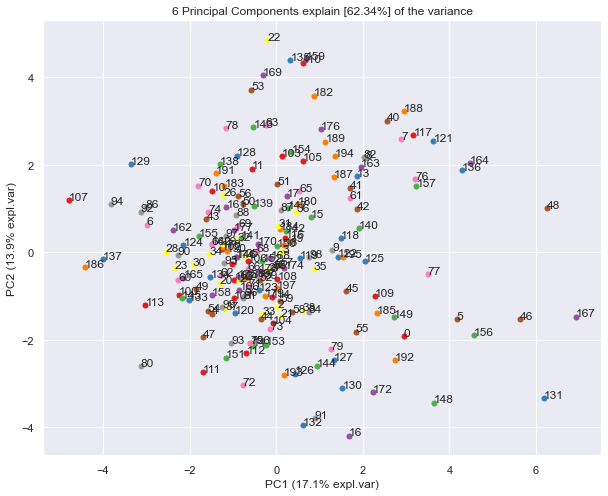

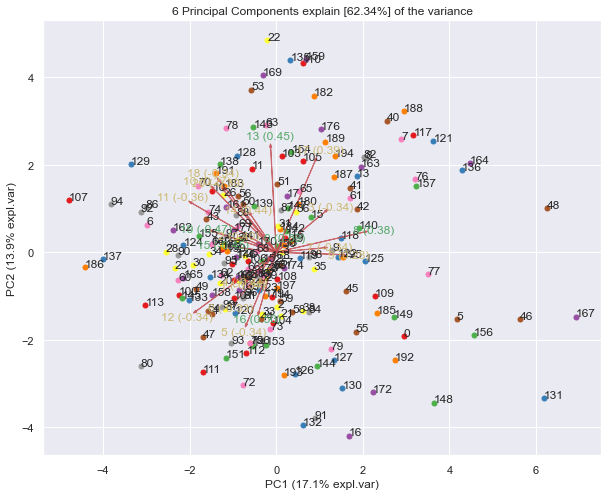

In [43]:
# reduce the data towards 5 PCs
model = pca_2(n_components=6)
# Fit transform
x.columns = pd.RangeIndex(x.columns.size)
x.columns  = x.columns.astype(str)
results = model.fit_transform(x)
# Plot explained variance
#fig, ax = model.plot()
fig, ax = model.scatter(legend=False)
# Make biplot with the number of features
fig, ax = model.biplot(n_feat=25, legend=False)

<b>Observations:</b>
- The 21 arrows dispersing out from the biplot diagram represents the 21 features in the 2 dimensional space. From the figure, there is a total of 156 points with each point representing the type of dog breed.

In [44]:
# add the cluster number to the original scaled data
#x_clustered = pd.DataFrame(X_scaled,columns=dataset.columns,index=y_train)
#x_clustered['cluster'] = clusters

#display_parallel_coordinates(x_clustered,3)

In [45]:
#display_factorial_planes(X_reduced,2,pca, [(0,1)], illustrative_var=clusters,alpha=0.8)
#plt.scatter(centres_reduced[:,0], centres_reduced[:,1], marker='x', s=169, linewidths=3,
#           color='k', zorder=10)

In [46]:
#centres_reduced = pca.transform(kmeans.cluster_centers_)

### K-Means clustering the dataset

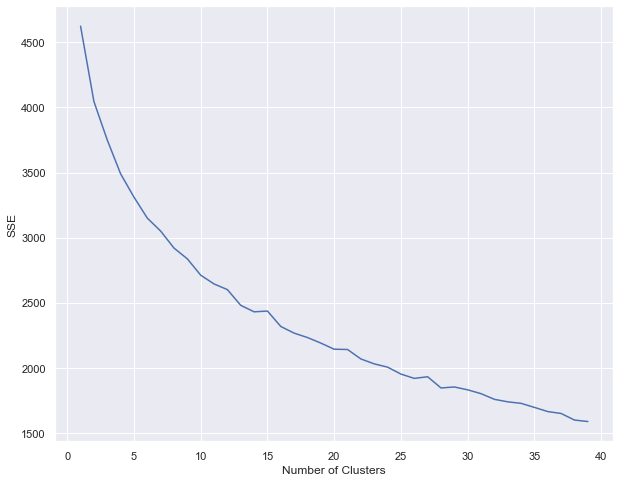

In [47]:
from sklearn import cluster

# Convert X_pca_2 into dataframe
pca_df = pd.DataFrame(x_pca, columns=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6'])
pca_df

# dis = distance.cdist(X_pca_2, X_pca_2, 'euclidean')
# print(dis)

# Make plot outputs appear and be stored within the notebook
%matplotlib inline

plt.rcParams["figure.figsize"] = (10,8)

numClusters = range(1,40)
SSE = []
for k in numClusters:
    k_means = cluster.KMeans(n_clusters=k)
    k_means.fit(dataset)
    SSE.append(k_means.inertia_) # Sum of squared distances of samples to their closest cluster center

plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.plot(numClusters, SSE)

Knee point around 13. K therefore set to 13.

In [48]:
k_means = cluster.KMeans(n_clusters=13, max_iter=50, random_state=1)
k_means.fit(pca_df) 
to_cluster_pca_df = pca_df
labels = k_means.labels_
print('labels:', labels)
clusterID = pd.DataFrame(labels, columns=['Cluster ID'])
# to_cluster_pca_df['Cluster ID'] = labels
# sorted_pca_df = to_cluster_pca_df.sort_values(['Cluster ID'], ascending = True)
# sorted_pca_df
clusterID

labels: [ 7  1  1  2  2  7 12  0 10  7 12  4  1 10 11  6  3  4  6  6  8  1 10 12
  1  1  4  6  9  6  6  6  6 11  6  6  4  1 11  1 10 10  0  1  8  1  7  8
  5  8  9  4  6 10  9  2  4  1  2 11 12  4  8 10  9  4  1  1  1  6  9  1
 11  3  6 11  5  7  4 11 12  6 10  1  2  6 12  1  9  1  6 11 12  9 12  8
  6  1  2  1 12 11  1  4  6  4  6 12  6  0 10  8 11  9  1 11  2 10  0  2
 11  0  2  6  8  0 11 11  4 12  3  5  3  1  9 10  5 12  4  4  7  6  1  4
  3  8  6  6  3  7  6 11  1  8  4 12  5  5  2 10  9  6  9 10  5  8  6  5
  6 10  2  6  3  1  1  1 10  6  6  8  0  1 10  4  1  2 12 10 10 10  2  4
  7  3 10  0 11  2]


Cluster ID
0             7
1             1
2             1
3             2
4             2
..          ...
193           3
194          10
195           0
196          11
197           2

[198 rows x 1 columns]

In [49]:
# Centroids
centroids = k_means.cluster_centers_
centroids_df= pd.DataFrame(centroids,columns=pca_df.columns)
centroids_df

PCA1      PCA2      PCA3      PCA4      PCA5      PCA6
0   2.030924  0.779324 -2.541244  0.230786 -1.942920 -0.251474
1  -0.490771 -0.410236 -0.638743  0.925506  1.218719  0.773731
2   0.275195 -0.637183  3.183357 -1.059598 -0.603675  0.178745
3   1.336711 -3.135271  0.775610  1.284505 -0.207850 -0.350887
4  -0.312516  1.768203  0.569400 -0.054832  0.179069 -0.624355
5   4.890727  0.174381  1.640285 -0.594605  1.209992 -0.186632
6  -0.582780 -0.058819 -0.238072 -0.914458 -0.122855 -0.186266
7   3.112264 -1.101932 -1.599614 -0.169550  0.492248 -1.452122
8  -1.364705 -1.089992  0.105183  0.620329 -1.323782  1.417729
9  -1.690023 -0.077009  0.532666  2.492847 -0.501715 -1.519379
10  1.213354  2.999261 -0.247645  0.266326 -0.243516  0.790966
11 -0.183229 -2.012330 -1.234518 -1.184497 -0.898769  0.232644
12 -3.055131  0.259317  0.222121 -0.774611  1.194161 -0.758142

With the 13 centroids we can now find out which dog breed belongs to which cluster. Furthermore, we will be able to predict which group a newly introduced data point will belong to.

### Post Processing & Exploring Cluster Information
In post processing, we will be exploring the clusters that were generated in the previous section.

In [50]:
# Grouping original dataset via label

dataset_cluster = dataset.copy()
dataset_cluster['Cluster ID'] = labels
dataset_cluster.index = index_list
dataset_cluster = dataset_cluster.sort_values(['Cluster ID'], ascending = True)
dataset_cluster.columns

Index(['shedding', 'groom', 'weight_gain', 'drooling', 'general_health',
       'size', 'wander', 'prey_drive', 'mouthiness', 'bark', 'train',
       'playful', 'exercise_intensity', 'novice_owners', 'sensitivity',
       'hot_weather', 'alone', 'apartment', 'family_affection', 'kid_friendly',
       'dog_friendly', 'Cluster ID'],
      dtype='object')

In [51]:
# Create 13 cluster df
c0 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 0]
c1 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 1]
c2 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 2]
c3 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 3]
c4 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 4]
c5 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 5]
c6 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 6]
c7 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 7]
c8 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 8]
c9 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 9]
c10 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 10]
c11 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 11]
c12 = dataset_cluster.loc[dataset_cluster['Cluster ID'] == 12]

In [52]:
# Dropping Label before PCA
c0 = c0.drop(['Cluster ID'], axis = 1)
c1 = c1.drop(['Cluster ID'], axis = 1)
c2 = c2.drop(['Cluster ID'], axis = 1)
c3 = c3.drop(['Cluster ID'], axis = 1)
c4 = c4.drop(['Cluster ID'], axis = 1)
c5 = c5.drop(['Cluster ID'], axis = 1)
c6 = c6.drop(['Cluster ID'], axis = 1)
c7 = c7.drop(['Cluster ID'], axis = 1)
c8 = c8.drop(['Cluster ID'], axis = 1)
c9 = c9.drop(['Cluster ID'], axis = 1)
c10 = c10.drop(['Cluster ID'], axis = 1)
c11 = c11.drop(['Cluster ID'], axis = 1)
c12 = c12.drop(['Cluster ID'], axis = 1)

# Store clusters into an array
clus_arr = [c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12]

In [53]:
clus = 0
for i in clus_arr:
    pca = PCA(n_components=1) #covariance matrix
    pca = pca.fit(i)

    components = pd.DataFrame(pca.components_, columns=i.columns)
    components.rename(index= lambda x:'Cluster-' + str(clus), inplace=True)

    # Top 3 positive contributors
    temp = pd.DataFrame(components.columns.values[np.argsort(-components.values,axis=1)[:,:2]], 
                 index=components.index, columns=['1st Max', '2nd Max'])
    print(temp)
    clus +=1
    


             1st Max        2nd Max
Cluster-0  apartment  novice_owners
          1st Max   2nd Max
Cluster-1   groom  drooling
            1st Max    2nd Max
Cluster-2  shedding  apartment
            1st Max      2nd Max
Cluster-3  drooling  sensitivity
            1st Max 2nd Max
Cluster-4  drooling   groom
          1st Max   2nd Max
Cluster-5    size  shedding
          1st Max    2nd Max
Cluster-6   groom  apartment
                      1st Max           2nd Max
Cluster-7  exercise_intensity  family_affection
          1st Max       2nd Max
Cluster-8  wander  dog_friendly
            1st Max 2nd Max
Cluster-9  drooling   groom
           1st Max      2nd Max
Cluster-10   groom  weight_gain
           1st Max   2nd Max
Cluster-11    bark  drooling
              1st Max      2nd Max
Cluster-12  apartment  sensitivity


In [54]:
eg1=clus_arr[0].iloc[[0]]
print(eg1.values.tolist())
clus_arr[0]

[[5, 5, 3, 5, 5, 3, 5, 5, 3, 5, 3, 3, 3, 1, 5, 3, 1, 5, 5, 3, 2]]


shedding  groom  weight_gain  drooling  general_health  \
Xoloitzcuintli            5      5            3         5               5   
Italian Greyhound         4      5            1         5               2   
Toy Fox Terrier           4      5            2         4               2   
Saluki                    4      4            1         5               4   
Whippet                   4      5            1         5               3   
Chihuahua                 4      5            3         5               2   
Greyhound                 3      5            2         5               3   
Ibizan Hound              5      5            1         5               4   

                   size  wander  prey_drive  mouthiness  bark  ...  playful  \
Xoloitzcuintli        3       5           5           3     5  ...        3   
Italian Greyhound     1       4           5           4     3  ...        4   
Toy Fox Terrier       1       4           5           2     2  ...        4   
Saluki                4       5           5           4     4  ...        4   
Whippet               3       4           5           3     3  ...        4   
Chihuahua             1       2           5           4     1  ...        3   
Greyhound             4       4           5           4     4  ...        4   
Ibizan Hound          3       4           5           3     4  ...        3   

                   exercise_intensity  novice_owners  sensitivity  \
Xoloitzcuintli                      3              1            5   
Italian Greyhound                   1              4            4   
Toy Fox Terrier                     4              3            3   
Saluki                              2              2            4   
Whippet                             3              4            4   
Chihuahua                           2              4            5   
Greyhound                           2              4            3   
Ibizan Hound                        3              3            3   

                   hot_weather  alone  apartment  family_affection  \
Xoloitzcuintli               3      1          5                 5   
Italian Greyhound            3      1          5                 5   
Toy Fox Terrier              3      1          5                 4   
Saluki                       4      2          2                 5   
Whippet                      4      2          3                 5   
Chihuahua                    3      1          5                 5   
Greyhound                    5      2          4                 5   
Ibizan Hound                 4      2          3                 5   

                   kid_friendly  dog_friendly  
Xoloitzcuintli                3             2  
Italian Greyhound             1             3  
Toy Fox Terrier               2             2  
Saluki                        3             2  
Whippet                       4             3  
Chihuahua                     2             2  
Greyhound                     3             3  
Ibizan Hound                  4             3  

[8 rows x 21 columns]

We will be using sample "Azawakh" as our first input

In [55]:
eg2=clus_arr[6].iloc[[0]]
print(eg2.values.tolist())
clus_arr[6]

[[4, 1, 4, 4, 3, 3, 4, 2, 2, 3, 4, 4, 5, 3, 3, 3, 3, 1, 5, 5, 4]]


shedding  groom  weight_gain  drooling  \
Boykin Spaniel                             4      1            4         4   
Brittany                                   3      3            3         5   
Wirehaired Pointing Griffon                3      3            3         3   
Siberian Husky                             2      2            3         5   
Irish Setter                               2      2            3         3   
Stabyhoun                                  3      3            3         4   
Nova Scotia Duck Tolling Retriever         2      3            4         3   
Scottish Deerhound                         4      4            2         3   
English Setter                             2      2            3         3   
Finnish Lapphund                           1      2            3         5   
Pharaoh Hound                              4      4            3         4   
Gordon Setter                              2      2            3         3   
German Shorthaired Pointer                 4      5            3         4   
Greater Swiss Mountain Dog                 3      5            4         2   
Schnoodle                                  3      5            4         1   
Irish Water Spaniel                        4      4            3         3   
Welsh Springer Spaniel                     2      3            3         3   
German Wirehaired Pointer                  3      3            3         3   
American Water Spaniel                     4      3            3         2   
Appenzeller Sennenhunde                    3      5            3         3   
Irish Red and White Setter                 3      3            3         4   
English Springer Spaniel                   3      3            3         3   
Cesky Terrier                              5      2            4         5   
Chesapeake Bay Retriever                   3      3            3         3   
Otterhound                                 3      3            3         3   
Swedish Vallhund                           1      5            4         5   
Curly-Coated Retriever                     4      4            3         3   
Rhodesian Ridgeback                        3      5            3         4   
Puggle                                     5      5            5         3   
Portuguese Water Dog                       5      2            3         3   
Barbet                                     4      1            3         4   

                                    general_health  size  wander  prey_drive  \
Boykin Spaniel                                   3     3       4           2   
Brittany                                         3     3       4           2   
Wirehaired Pointing Griffon                      4     4       4           2   
Siberian Husky                                   3     4       5           3   
Irish Setter                                     2     4       4           3   
Stabyhoun                                        3     3       3           3   
Nova Scotia Duck Tolling Retriever               2     3       3           4   
Scottish Deerhound                               2     5       4           5   
English Setter                                   3     4       4           3   
Finnish Lapphund                                 4     3       4           3   
Pharaoh Hound                                    4     3       4           5   
Gordon Setter                                    2     4       4           3   
German Shorthaired Pointer                       3     4       4           2   
Greater Swiss Mountain Dog                       3     5       3           4   
Schnoodle                                        4     4       3           3   
Irish Water Spaniel                              4     4       3           3   
Welsh Springer Spaniel                           2     3       4           3   
German Wirehaired Pointer                        3     4       4           2   
American Water Span

#### We will be using a slightly editted Australian Cattle Dog data as input.
##### The original: [3, 4, 4, 5, 3, 3, 4, 4, 1, 1, 5, 5, 5, 3, 4, 4, 3, 2, 5, 2, 3]
##### Our test input: [3, 5, 3, 5, 3, 2, 4, 4, 1, 1, 4, 4, 5, 3, 4, 4, 3, 2, 4, 2, 3]

### Predict user input

In [56]:
#assuming as the most contributed feature of every pc is asked only
# from sklearn import preprocessing

# eg_input = [1,2,3,4,5,1]
# standardized_input = preprocessing.scale(eg_input)
# standardized_input

# List of questions based on the highest contribution features for each PC

['shedding', 'groom', 'weight_gain', 'drooling', 'general_health',
       'size', 'wander', 'prey_drive', 'mouthiness', 'bark', 'train',
       'playful', 'exercise_intensity', 'novice_owners', 'sensitivity',
       'hot_weather', 'alone', 'apartment', 'family_affection', 'kid_friendly',
       'dog_friendly']

list_of_qn=["1. I do not mind a dog that sheds its fur often: ",
            "2. I prefer a dog that is easy to groom: ",
            "3. I do not mind a dog that can gain weight easily: ",
            "4. I do not mind my dog drooling: ",
            "5. A dog that is resistant to illnesses is important: ",
            "6. I prefer a big dog: ",
            "7. I prefer a dog that wanders around on it's own: ",
            "8. I prefer a dog that chases and hunts for small prey: ",
            "9. I do not mind a dog that likes chewing on things: ",
            "10. I prefer a dog that barks: ",
            "11. I want a dog that is easy to train: ",
            "12. I prefer a playful dog: ",
            "13. I like taking my dog out for walks: ",
            "14. I have little to no experience raising dogs: ",
            "15. My home is generally quiet without loud sounds or distractions: ",
            "16. I would like to bring my dog out and excercise on a hot sunny day: ",
            "17. I prefer a dog that is able to be by itself and not crave attention: ",
            "18. I prefer my dog to be calm indoors and polite with strangers: ",
            "19. I prefer a dog that is affectionate with my family members: ",
            "20. The dog has to be friendly with small kids & children: ",
            "21. I would like my dog to be friendly and not dominate other dogs: "
         ]

In [ ]:
from numpy import dot
from numpy.linalg import norm
import numpy as np
from sklearn import preprocessing
from pandas import DataFrame
def is_valid(user_input):
    try:
        test = int(user_input)
        if test > 0 and test <= 5:
            return True
        else:
            print("Input not valid, enter input again.")
            return False  
    except:
        print("Input not valid, enter input again.")
        return False
    
print("Hi, I will be recommending 5 dog breeds to you today.")
print("For each question, enter a number from 1 to 5.")
print("1 = Strongly disagree. 5 = Strongly agree.")

list_of_ans=[]

for n in range(len(list_of_qn)):
    next_qns = False
    while next_qns == False:
        user_in = input(list_of_qn[n])
        user_in = int(user_in)
        if is_valid(user_in):
            list_of_ans.append(int(user_in))
            next_qns = True
            
print("Inputs:", list_of_ans)


user_input = np.array(list_of_ans).reshape(-1, 1)
user_input = preprocessing.scale(user_input)
user_input = user_input.reshape(1, -1)

# Fit and transform user inputs
pca = PCA(n_components= 6)
pca.fit(pca_fitting_dataset)
user_pca = pca.transform(user_input)

k_means.fit(pca_df) 
ans = k_means.predict(user_pca)
ans = ans[0]

chosen_cluster = clus_arr[ans]

newDF = pd.DataFrame() #creates a new dataframe that's empty
newDF = newDF.append(chosen_cluster, ignore_index = False) #chosen cluster is Cluster 
result_list = [] #to print the results from cosine formula 

for i,row in newDF.iterrows():
    #gets the result from the dataframe without header and index 
    #loc is used to return the result from each row of the dataset using label
    #row.name is to get the label of each row from the dataset
    i_Values = newDF.loc[row.name].values 
    #returns dot product of two arraws - list_of_ans and 
    dot_Result = dot(list_of_ans,i_Values)
    cos_sim = dot_Result / (norm(list_of_ans)*norm(i_Values))
    result = (row.name,cos_sim)
    result_list.append(result)
    
result_list.sort(key=lambda x:x[1])
result_list[:5]

labels = ['Breed', 'Angle']
result_df = DataFrame(result_list[:5],columns=['Breed', 'Cosine'])
print("According to your desired dog features, Top 5 Breeds to consider are as follows: \n",result_df['Breed'].to_string(index=False))


Hi, I will be recommending 5 dog breeds to you today.
For each question, enter a number from 1 to 5.
1 = Strongly disagree. 5 = Strongly agree.


#First run we will use input: [3, 5, 3, 5, 3, 3, 2, 4, 4, 3, 2, 2, 3, 2, 3, 4, 3, 2, 3, 3, 3]
#### Second run we will use input: [3, 5, 3, 5, 3, 2, 4, 4, 1, 1, 4, 4, 5, 3, 4, 4, 3, 2, 4, 2, 3]

In [ ]:
# Again, these are the clusters that we have.
# k_means.labels_

In [ ]:
# LASTLY use the inputs for comparison

Getting cluster from user input

In [ ]:
# from sklearn import preprocessing
# print(list_of_ans)
# user_input = np.array(list_of_ans).reshape(-1, 1)
# user_input = preprocessing.scale(user_input)
# user_input = user_input.reshape(1, -1)

# # Fit and transform user inputs
# pca = PCA(n_components= 6)
# pca.fit(pca_fitting_dataset)
# user_pca = pca.transform(user_input)

# k_means.fit(pca_df) 
# ans = k_means.predict(user_pca)
# ans = ans[0]
# print("User input belongs to cluster:",ans)
# chosen_cluster = clus_arr[ans]
# chosen_cluster
# #clus_arr

### Rerun prediction of user input again under "Predict User Input"
On the 2nd time we will use a different sample

In [ ]:
#  from numpy import dot
#  from numpy.linalg import norm
#  import numpy as np

# newDF = pd.DataFrame() #creates a new dataframe that's empty
# newDF = newDF.append(chosen_cluster, ignore_index = False) #chosen cluster is Cluster 
# result_list = [] #to print the results from cosine formula 

#  for i,row in newDF.iterrows():
#     #gets the result from the dataframe without header and index 
#     #loc is used to return the result from each row of the dataset using label
#     #row.name is to get the label of each row from the dataset
#     i_ValuBes = newDF.loc[row.name].values 
#     #returns dot product of two arrays - list_of_ans and 
#     dot_Result = dot(list_of_ans,i_Values)
#     dot_result = (row.name,cos_sim)
#     result_list.append(result)

In [ ]:
# from pandas import DataFrame
# result_list.sort(key=lambda x:x[1])
# result_list[:5]

# labels = ['Breed', 'Angle']
# result_df = DataFrame(result_list[:5],columns=['Breed', 'Cosine'])
